# 0. Скоринговая модель и карта баллов на данных German Credit
Анализ, выводы + модель ИИ 
___
**Цель проекта:** построить интерпретируемую модель кредитного риска (вероятности дефолта заемщика, PD) на классическом датасете German Credit.

**Бизнес-контекст:** построение скоринговой модели может быть полезно банкам и финансовым компаниям для автоматизированного принятия решений по заявкам на заём средств. Они помогают снижать риск невозврата и оптимизировать прибыль портфеля.

**Набор данных:** В работе используется <a href="https://www.kaggle.com/datasets/kabure/german-credit-data-with-risk">German Credit Dataset</a> — классический набор данных для задач кредитного скоринга/

___
- <a href="../data">Данные</a>
- <a href="../notebooks">Jupyter-ноутбуки</a>
- <a href="../reports">Отчёты</a> (в процессе)
- <a href="../reports/model-report-app.py">Интерактивный отчёт</a> (в процессе)
- <a href="../src/models">МОДЕЛИ</a> (в процессе)

# 1. Инициализация и подготовка данных

### 1.1. Общие данные 

In [74]:
import os
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (8, 6)
%matplotlib inline

In [75]:
df = pd.read_csv('../data/raw/german_credit_data.csv')
display(df.head())
display(df.tail())

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
995,995,31,female,1,own,little,NaN,1736,12,furniture/equipment,good
996,996,40,male,3,own,little,little,3857,30,car,good
997,997,38,male,2,own,little,NaN,804,12,radio/TV,good
998,998,23,male,2,free,little,little,1845,45,radio/TV,bad
999,999,27,male,2,own,moderate,moderate,4576,45,car,good


In [76]:
print(f'ИНФОРМАЦИЯ\n')
display(df.info())
display(f'Размерность: {df.shape[0]} записей на {df.shape[1]} признаков')

ИНФОРМАЦИЯ

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving accounts   817 non-null    object
 6   Checking account  606 non-null    object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
 10  Risk              1000 non-null   object
dtypes: int64(5), object(6)
memory usage: 86.1+ KB


None

'Размерность: 1000 записей на 11 признаков'

## Данные принаки:
- ```Unnamed: 0``` - порядковый номер клиента (не нужен)
- ```Age``` - возраст клиента
- ```Sex``` - Пол клиента
- ```Job``` - Квалификация профессии клиента: 
    - 0 = неквалифицированный, безработный
    - 1 = неквалифицированный, но работающий
    - 2 = квалифицированный, работающий
    - 3 = высококвалифицированный/руководитель
- ```Housing``` - жилищные условия:
    - _own_ - собственное жильё;
    - _rent_ - съёмное жильё;
    - _free_ - живёт бесплатно
- ```Saving accounts``` - Сбережения клиента
- ```Checking account``` - Состояние текущего счёта
- ```Credit amount``` - Размер кредита (DM, Немецкие Марки)
- ```Duration``` - Срок кредита (месяц).
- ```Purpose``` - Цель кредита
- **```Risk```** - **целевой признак**, надёжность клиента (Да/Нет).

### 1.2. Препроцессинг: регулировка данных, проверка на валидность и пользу данных.

In [77]:
df = df.drop(columns=['Unnamed: 0']) # Ненужные порядковые данные с ID клиента
# Переименование колонок для удобной работы: приведение к нижнему регистру и подчёркиванию, как разделитель.
df.columns = df.columns.str.lower()
df.columns = df.columns.str.replace(' ', '_')
df.head(1)

,age,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose,risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good


In [78]:
# Проверка на пропуски
# Функция для заполнения пропусков в исходных данных
def fill_original():
    filled_df = df.copy()
    # Пропущенные данные будут заменены на no_info
    filled_df['saving_accounts'] = filled_df['saving_accounts'].fillna('no_info')
    filled_df['checking_account'] = filled_df['checking_account'].fillna('no_info')
    return filled_df

if df.isna().any().any():
    print(f'Пропущенные значения:\n{df.isna().sum()}')
    df = fill_original()
else:
    print('Нет пропущенных значений.')

Пропущенные значения:
age                   0
sex                   0
job                   0
housing               0
saving_accounts     183
checking_account    394
credit_amount         0
duration              0
purpose               0
risk                  0
dtype: int64


In [79]:
num_of_duplicated = df.duplicated().sum()

if num_of_duplicated:
    print(f'Обнаружено дупликатов: {num_of_duplicated}')
    df = df.drop_duplicates()
    print(f'Все дупликаты очищены. Кол-во записей: {df.shape[0]}')
else:
    print('Дупликатов нет.')

Дупликатов нет.


In [80]:
# Преобразование признака риска в числовое значение
df['risk'] = df['risk'].map({
    'bad': 0,
    'good': 1
})
df.head()

,age,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose,risk
0,67,male,2,own,no_info,little,1169,6,radio/TV,1
1,22,female,2,own,little,moderate,5951,48,radio/TV,0
2,49,male,1,own,little,no_info,2096,12,education,1
3,45,male,2,free,little,little,7882,42,furniture/equipment,1
4,53,male,2,free,little,little,4870,24,car,0


# <mark>1. Отчёт</mark>
1) Имена признаков были изменены (нижний регистр, lowercase, пробелы заменены нижним подчёркиванием);
2) Проведена проверка на дупликаты и потерянные данные:
- Недостающие данные ```saving_accounts``` и ```checking_account``` были заменены на *no_info*
3) Признак ```risk``` был преобразован в числовую переменную для более удобного анализа:
- ```0``` - клиент ненадёжен;
- ```1``` - клиент надёжен.

___

# 2. Разведовательный анализ данных

### План:
- Распределения: гистограммы/boxplot для числовых; барплоты для категориальных (в %).

- Связь с таргетом: t-test/ANOVA для числовых; χ² (или Fisher) для категориальных; дефолт-рейт по категориям/бинам.

- Выбросы: детект (IQR/квантили), решение: биннинг / лог-трансформация / винсоризация (минимально).

- Корреляции и коллинеарность: Pearson/Spearman для числовых, Cramer’s V для категориальных, VIF.

In [81]:
df.dtypes

age                  int64
sex                 object
job                  int64
housing             object
saving_accounts     object
checking_account    object
credit_amount        int64
duration             int64
purpose             object
risk                 int64
dtype: object

In [82]:
# Разделение признаков на числовые и категориальные.
num_features = ['age', 'credit_amount', 'duration']
num_features_labels = ['Возраст', 'Размер кредита', 'Длительность кредита']
# _____
cat_features = ['sex', 'job', 'housing', 'saving_accounts', 'checking_account', 'purpose']
cat_features_labels = ['Пол клиента', 'Тип занятости клиента', 'Жилищные условия клиента', 'Уровень сбережений', 'Состояние текущего счёта', 'Цель кредита']

target = 'risk'

## 2.1 Распределение признаков
### 2.1.1. Числовые признаки

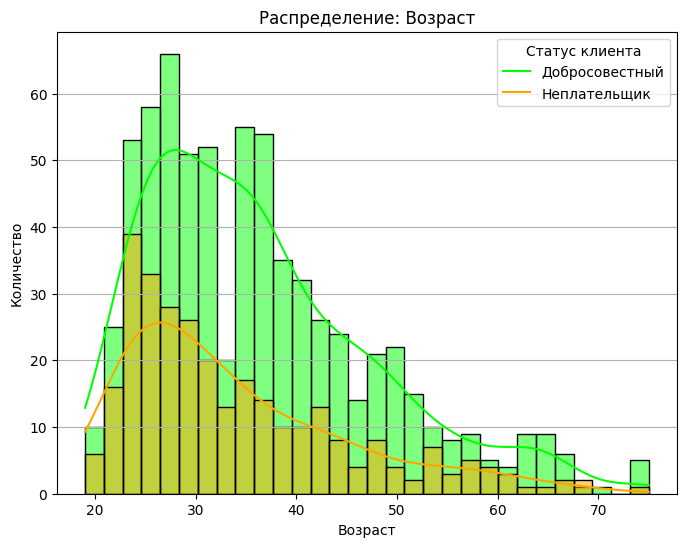

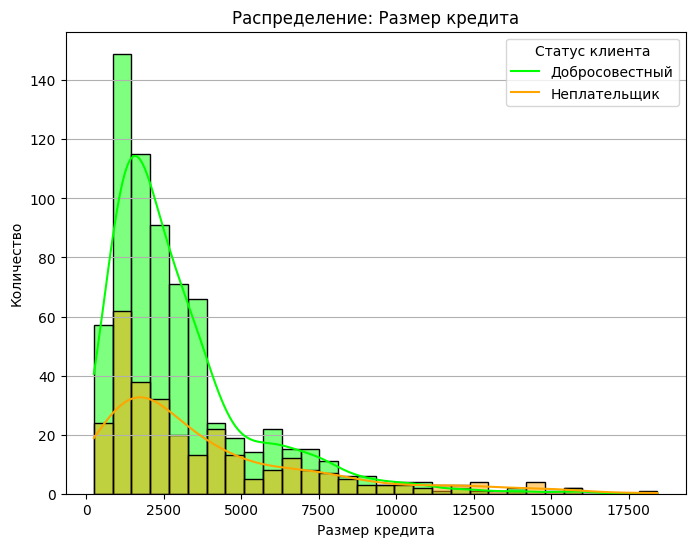

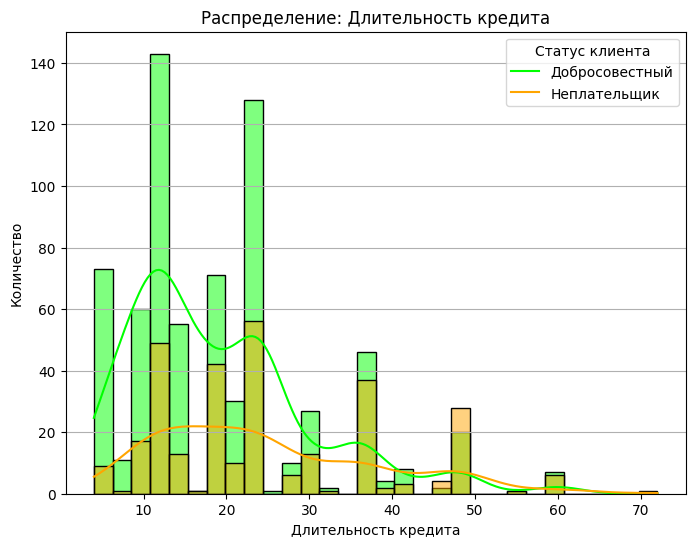

In [83]:
for feature, feature_name in zip(num_features, num_features_labels):
    sns.histplot(data=df, x=feature, hue=target, kde=True, bins=30, palette={0: 'orange', 1: 'lime'})
    plt.title(f'Распределение: {feature_name}')
    plt.xlabel(feature_name)
    plt.ylabel('Количество')
    plt.grid(axis='y')
    plt.legend(title='Статус клиента',
               labels=['Добросовестный', 'Неплательщик'],
               loc='best')
    plt.show()

2.1.2. Категориальные признаки

* Для подписей признаков необходимо посмотреть все уникальные значения каждого категориального признака 

In [84]:
for feature in cat_features:
    print(f'{feature}: {df[feature].unique()}')
    print('_' * 5)

sex: ['male' 'female']
_____
job: [2 1 3 0]
_____
housing: ['own' 'free' 'rent']
_____
saving_accounts: ['no_info' 'little' 'quite rich' 'rich' 'moderate']
_____
checking_account: ['little' 'moderate' 'no_info' 'rich']
_____
purpose: ['radio/TV' 'education' 'furniture/equipment' 'car' 'business'
 'domestic appliances' 'repairs' 'vacation/others']
_____


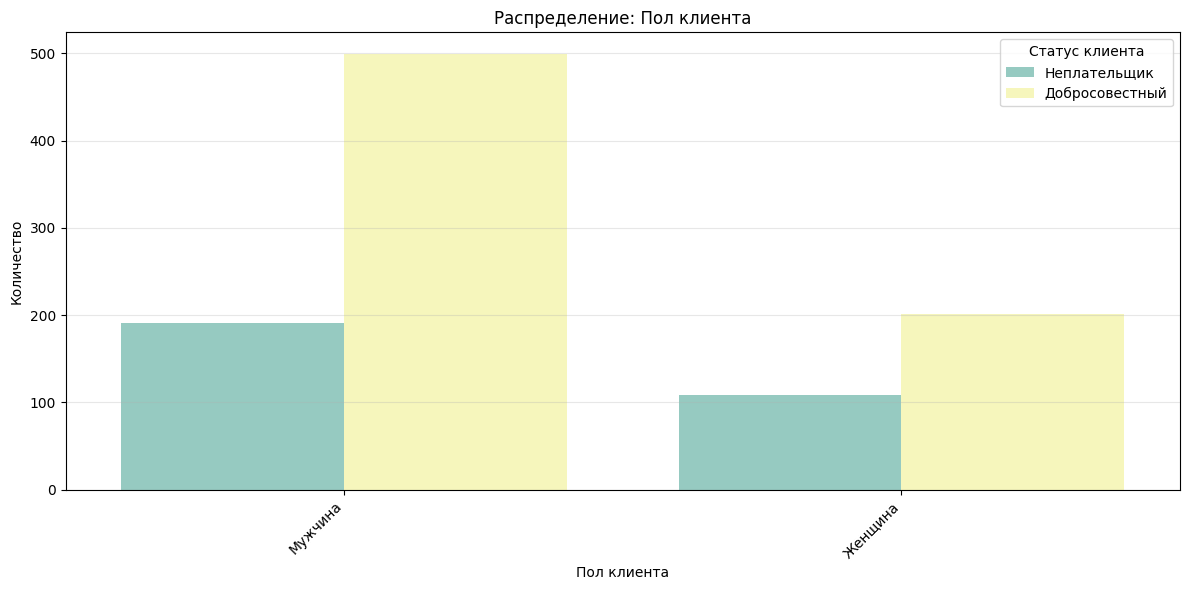

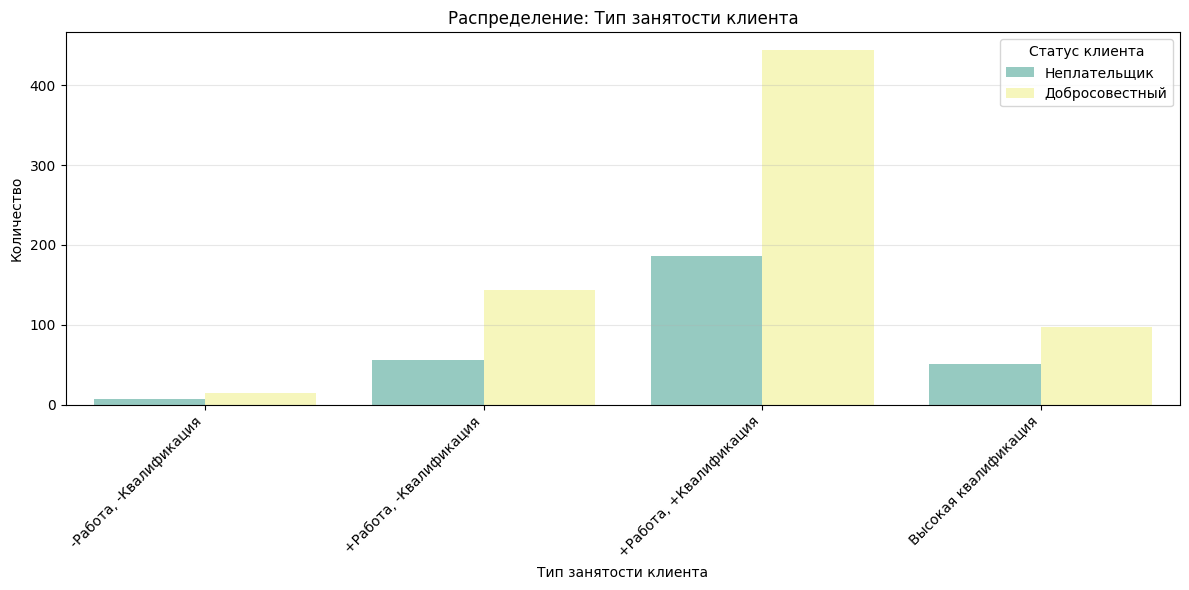

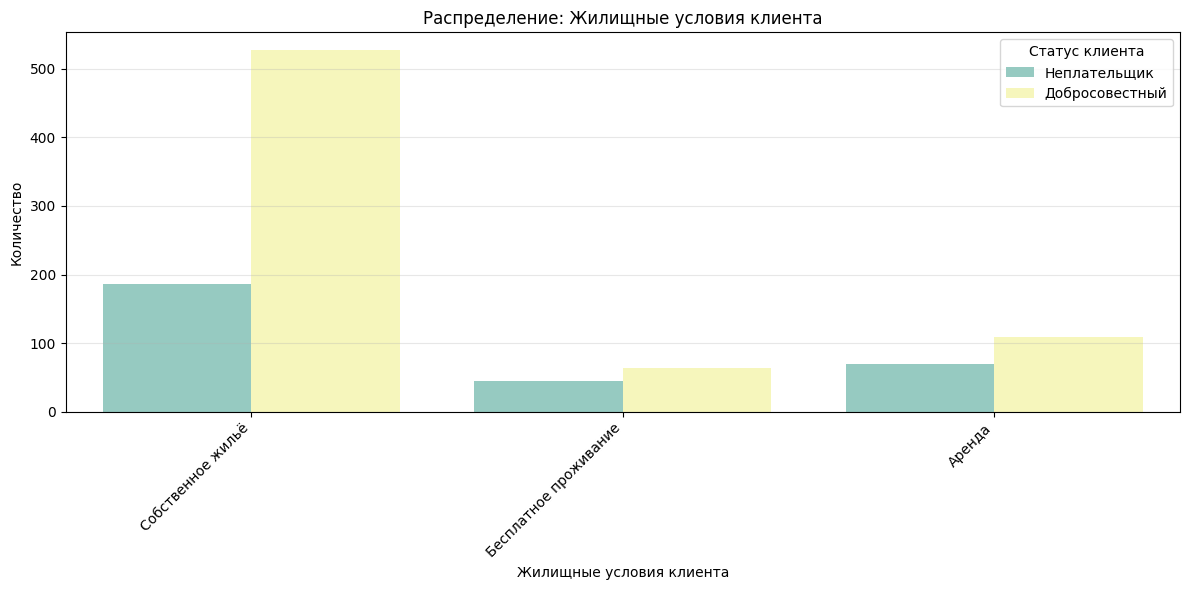

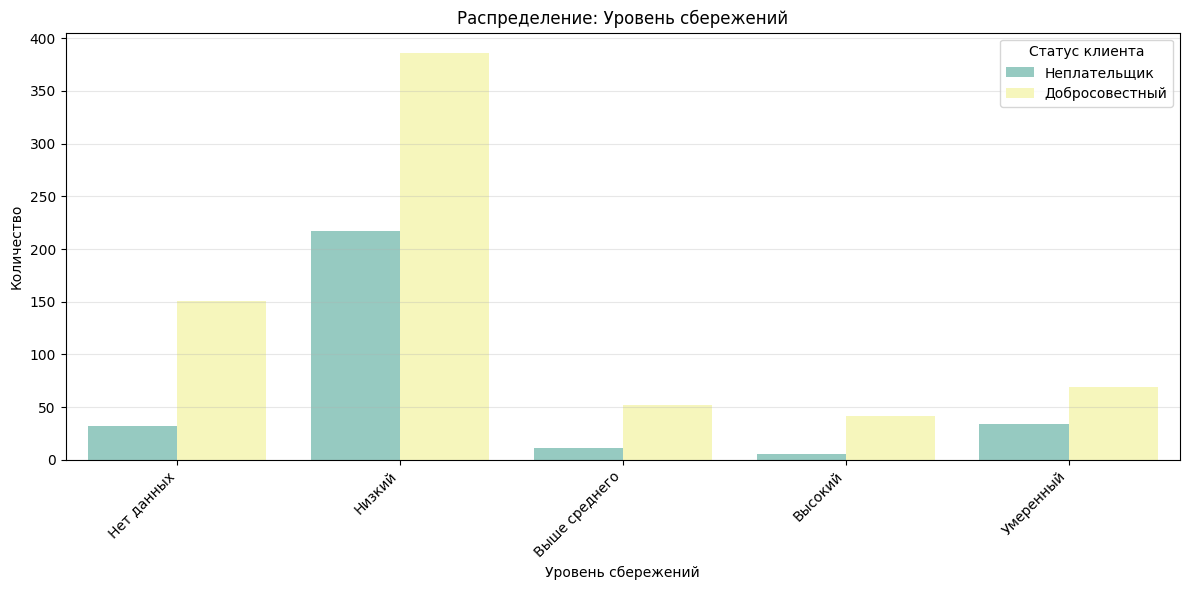

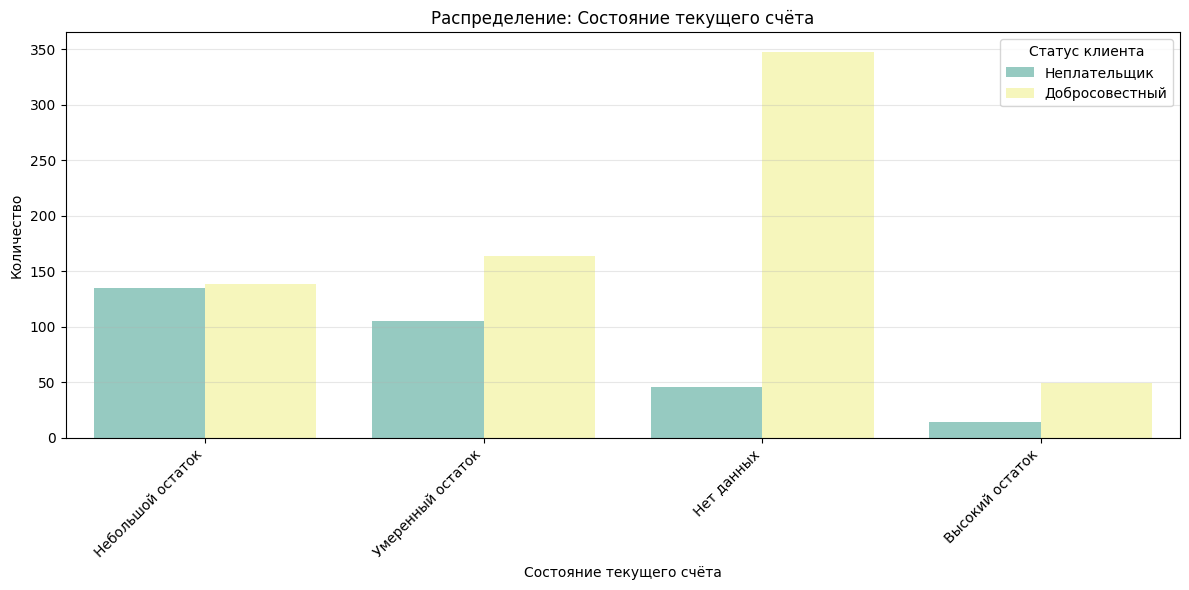

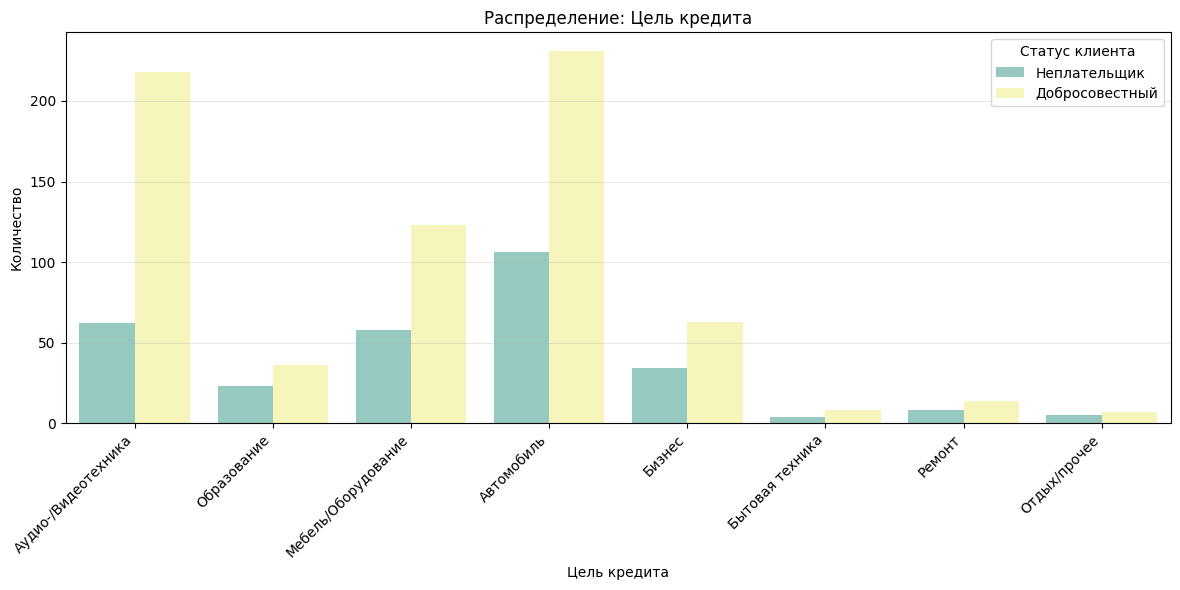

In [85]:
cat_xticks = [
    ['Мужчина', 'Женщина'],
    ['-Работа, -Квалификация', '+Работа, -Квалификация', '+Работа, +Квалификация', 'Высокая квалификация'],
    ['Собственное жильё', 'Бесплатное проживание', 'Аренда'],
    ['Нет данных', 'Низкий', 'Выше среднего', 'Высокий', 'Умеренный'],
    ['Небольшой остаток', 'Умеренный остаток', 'Нет данных', 'Высокий остаток'],
    ['Аудио-/Видеотехника', 'Образование', 'Мебель/Оборудование', 'Автомобиль', 'Бизнес', 'Бытовая техника', 'Ремонт', 'Отдых/прочее']
]

for i, (feature, feature_name) in enumerate(zip(cat_features, cat_features_labels)):
    plt.figure(figsize=(12, 6))
    ax = sns.countplot(data=df, x=feature, hue=target, palette='Set3')
    
    # Установка русских подписей для xticks
    plt.xticks(ticks=range(len(cat_xticks[i])), labels=cat_xticks[i], rotation=45, ha='right')
    
    plt.title(f'Распределение: {feature_name}')
    plt.grid(axis='y', alpha=0.3)
    plt.xlabel(feature_name)
    plt.ylabel('Количество')
    plt.legend(title='Статус клиента', 
               labels=['Неплательщик', 'Добросовестный'],
               loc='best')
    plt.tight_layout()
    plt.show()

## <mark>2.1. Отчёт</mark> - визуальная оценка распределения данных.

### 2.1.1. Числовые данные
- Молодые клиенты **чаще** становятся **неплательщиками**, большинство **неплательщиков** сконцентрированы в возрасте 25-40 лет;

- Количество **неплательщиков** прямо пропорционально соответствует **размеру кредита**: чем больше сумма - тем больше неплательщиков. Диапазон самых оптимальных сумм кредита - от **2000** до **4000** немецких марок;

- **Риск невозврата** возрастает при **долгих сроках кредита**, самые надёжные сроки - от **2.5 месяцев** до **24 месяцев**.

### 2.1.2. Категориальные данные
- Большинство клиентов - **мужчины**, однако вне зависимости от пола, клиенты возвращают кредиты примерно в равном соотношении (менее половины неплательщиков);

- Больше всего клиентов **имеют работу и квалификацию** (профильное образование, специализированные курсы и так далее), но также не видно связи работы/квалификации и оплаты кредита;

- У большинства клиентов есть **собственная недвижимость**. Клиенты с **собственной недвижимостью чаще остальных имеют статус добросовестного плательщика**.

- Чаще всего встречаются клиенты с **низким уровнем сбережений**. Самые добросовестные клиенты имеют сбережения **выше среднего** или **высокие**.

- Неизвестна информация о состоянии **текущего счёта** у большинства клиентов, однако везде наблюдается **равное соотношение** плательщеков и неплательщеков;

- Самая **популярная** цель кредита - **автомобиль** или **аудио/видеотехника** и, как правило, _кредит на эти цели выплачивается_.

___

## 2.2. Статистические тесты

Для проверки статистической значимости на таргет (риск дефолта) проведены статистические тесты:
- t-test/ANOVA для числовых;
- χ² (или Fisher) для категориальных

In [86]:
from scipy import *
from scipy.stats import *

In [87]:
# Числовые признаки (ANOVA, t-test)
significant_num_features = []
insignificant_num_feautes = []

for feature, feature_name in zip(num_features, num_features_labels):
    risk_good = df[df['risk'] == 1][feature]
    risk_bad = df[df['risk'] == 0][feature]
    
    mean__risk_good = risk_good.mean()
    mean_risk_bad = risk_bad.mean()
    
    if len(risk_good) > 1 and len(risk_bad) > 1:
        t_stat, p_value = ttest_ind(risk_good, risk_bad, equal_var=False)
        # Средние значения по средним показателям признаков по риску
        mean_risk_good = risk_good.mean()
        mean_risk_bad = risk_bad.mean()
        
        print(f"{feature_name}:")
        print(f"  Добросовестные: {mean_risk_good:.2f}")
        print(f"  Неплательщики: {mean_risk_bad:.2f}")
        print(f"  p-value: {p_value:.4f}")
        print(f"  Стат. значимость: {'Да' if p_value < 0.05 else 'Нет'}")
        print("-" * 50)
        
        if p_value < 0.05:  # стандартный уровень значимости
            significant_num_features.append((feature, feature_name))
        else:
            insignificant_num_feautes.append((feature, feature_name))
    else:
        print(f"{feature_name}: Недостаточно данных для анализа")
        
        
print(f'СТАТИСТИЧЕСКИ ЗНАЧИМЫЕ ПРИЗНАКИ:\n{significant_num_features}')
print('_' * 50)
print(f'НЕЗНАЧИМЫЕ ПРИЗНАКИ:\n{insignificant_num_feautes}')

Возраст:
  Добросовестные: 36.22
  Неплательщики: 33.96
  p-value: 0.0038
  Стат. значимость: Да
--------------------------------------------------
Размер кредита:
  Добросовестные: 2985.46
  Неплательщики: 3938.13
  p-value: 0.0000
  Стат. значимость: Да
--------------------------------------------------
Длительность кредита:
  Добросовестные: 19.21
  Неплательщики: 24.86
  p-value: 0.0000
  Стат. значимость: Да
--------------------------------------------------
СТАТИСТИЧЕСКИ ЗНАЧИМЫЕ ПРИЗНАКИ:
[('age', 'Возраст'), ('credit_amount', 'Размер кредита'), ('duration', 'Длительность кредита')]
__________________________________________________
НЕЗНАЧИМЫЕ ПРИЗНАКИ:
[]


In [88]:
# Категориальные признаки (Хи-Квадрат тест)
significant_cat_features = []
insignificant_cat_feautes = []

for feature, feature_name in zip(cat_features, cat_features_labels):
    observed = pd.crosstab(index=df['risk'], columns=df[feature])
    chi, p_value, dof, expected = chi2_contingency(observed)
    
    print(feature_name)
    print(f'Статистическая значимость: {"Да" if p_value < .05 else "Нет"}')
    print(f'p-value: {p_value:.2f}')
    print('-' * 50)
    
    if p_value < 0.05:
        significant_cat_features.append((feature, feature_name))
    else:
        insignificant_cat_feautes.append((feature, feature_name))
        

print(f'СТАТИСТИЧЕСКИ ЗНАЧИМЫЕ ПРИЗНАКИ:\n{significant_cat_features}')
print('_' * 50)
print(f'НЕЗНАЧИМЫЕ ПРИЗНАКИ:\n{insignificant_cat_feautes}')

Пол клиента
Статистическая значимость: Да
p-value: 0.02
--------------------------------------------------
Тип занятости клиента
Статистическая значимость: Нет
p-value: 0.60
--------------------------------------------------
Жилищные условия клиента
Статистическая значимость: Да
p-value: 0.00
--------------------------------------------------
Уровень сбережений
Статистическая значимость: Да
p-value: 0.00
--------------------------------------------------
Состояние текущего счёта
Статистическая значимость: Да
p-value: 0.00
--------------------------------------------------
Цель кредита
Статистическая значимость: Нет
p-value: 0.06
--------------------------------------------------
СТАТИСТИЧЕСКИ ЗНАЧИМЫЕ ПРИЗНАКИ:
[('sex', 'Пол клиента'), ('housing', 'Жилищные условия клиента'), ('saving_accounts', 'Уровень сбережений'), ('checking_account', 'Состояние текущего счёта')]
__________________________________________________
НЕЗНАЧИМЫЕ ПРИЗНАКИ:
[('job', 'Тип занятости клиента'), ('purpose', '

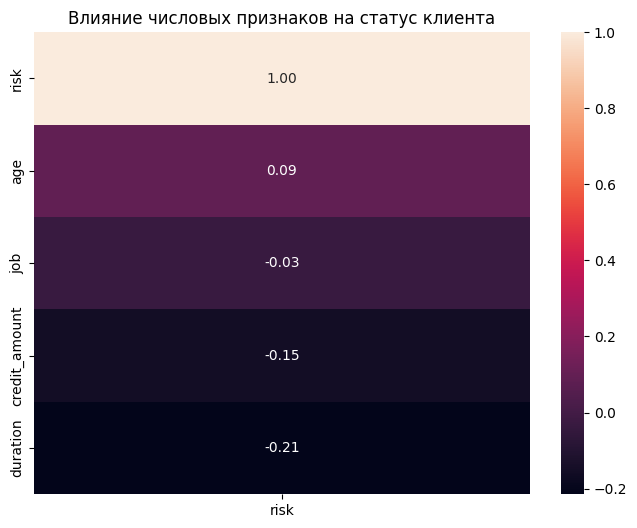

In [89]:
# Корреляция числовых признаков
df_corr = df.corr(numeric_only=True)

# Heatmap для корреляции числовых признаков по убыванию 
sns.heatmap(df_corr[['risk']].sort_values(by='risk', ascending=False),
            annot=True, fmt='.2f',
            cmap='rocket')
plt.title('Влияние числовых признаков на статус клиента')
plt.show()

## <mark>2.2. ОТЧЁТ</mark>

- Все числовые признаки (а также бинарный - по полу клиента) показывают статистически значимые различия между группами добросовестных клиентов и неплательщиков (p-value < 0.05); это:
    - Пол клиента;
    - Размер кредита;
    - Длительность кредита.

- Статистически значимые категориальные признаки:
    - Пол клиента;
    - Тип жилья клиента;
    - Уровень сбережений клиента; 
    - Состояние текущего счёта клиента.

- Влияние признаков на возврат кредита (**по убыванию силы корреляции**):
    - ПРЯМО ПРОПОРЦИОНАЛЬНАЯ КОРРЕЛЯЦИЯ:
        - Возраст `9/10` (чем больше возраст - тем больше шанс возврата кредита);
    - ПРОТИВ ПРОПОРЦИОНАЛЬНАЯ КОРРЕЛЯЦИЯ:
        - Срок кредита `-2/10` (Чем меньше срок - тем выше шанс возврата кредита)
        - Размер кредита `-1.5/10` (Чем меньше заёмных средств - тем выше шанс возврата кредита)

___

# 3. Feature Engineering - подготовка данных к моделированию

In [90]:
# Новый признак для улучшения качества модели: ежемесячный платёж по кредиту
df['monthly_payment'] = df['credit_amount'] / df['duration']
df.head(2)

,age,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose,risk,monthly_payment
0,67,male,2,own,no_info,little,1169,6,radio/TV,1,194.833333
1,22,female,2,own,little,moderate,5951,48,radio/TV,0,123.979167


## 3.1. Обработка категориальных признаков

In [91]:
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [92]:
X = df.drop(columns=['risk'])
y = df['risk']

In [93]:
# Трансформер (масштабирования) для числовых признаков. 
num_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Трансфорер (преобразования) для категориальных признаков.
cat_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Препроцессор для применения трансформеров к данным
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features), 
        ('cat', cat_transformer, cat_features)
    ]
)

preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['age', 'credit_amount', 'duration']),
                                ('cat',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['sex', 'job', 'housing', 'saving_accounts',
                                  'checking_account', 'purpose'])])

# <mark>3. Отчёт</mark>
- Был добавлен новый признак - ежемесячный плановый платёж по кредиту (частное суммы кредита к кол-ву месяцев)
- Преобразованы данные для читаемости моделью:
    - Числовые данные масштабированы к близким пропорциям;
    - Категориальные признаки преобзразованы в числовые с помощью `OneHotEncoder`.

___

# 4. Создание модели

Построение модели машинного обучения, оценка предсказательных моделей для задачи кредитного скоринга.

- Использовать **пайплайн** с предварительной обработкой признаков (масштабирование числовых и кодирование категориальных);
- Провести **кросс-валидацию**, чтобы надёжно оценить качество;
- Сравнить несколько алгоритмов (Logistic Regression, Random Forest, Gradient Boosting);
- Выбрать модель, которая даёт наилучший баланс между качеством и интерпретируемостью.

В качестве метрики будет использоваться ```ROC AUC```, так как классы несбалансированы, и важно правильно ранжировать клиентов по риску.

In [94]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score

In [95]:
# Модели:
models = {
    "Логистическая регрессия": LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42),
    "Случайный лес": RandomForestClassifier(
        n_estimators=300, max_depth=None, class_weight="balanced", random_state=42
    ),
    "Градиентный бустинг": GradientBoostingClassifier(random_state=42)
}

In [96]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # Кросс-валидация 5 итераций с разрешением повторения использованных данных

In [97]:
results = {}

for name, model in models.items():
    clf = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    scores = cross_val_score(clf, X, y, cv=cv, scoring='roc_auc')
    results[name] = (scores, scores.mean())
    
    print(f'--- Модель: {name} ---')
    print(f'Средняя точность: {scores.mean()}')
    print('_' * 100)

--- Модель: Логистическая регрессия ---
Средняя точность: 0.7425476190476191
____________________________________________________________________________________________________
--- Модель: Случайный лес ---
Средняя точность: 0.7483214285714286
____________________________________________________________________________________________________
--- Модель: Градиентный бустинг ---
Средняя точность: 0.7473452380952381
____________________________________________________________________________________________________


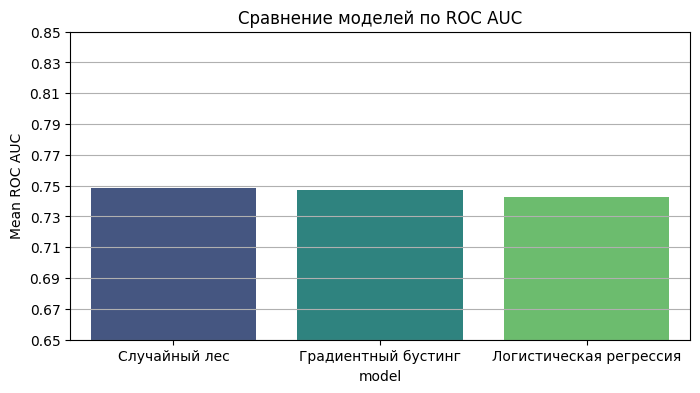

Рейтинг моделей:


,model,mean_roc_auc,auc_percentage
1,Случайный лес,0.748321,74.83
2,Градиентный бустинг,0.747345,74.73
0,Логистическая регрессия,0.742548,74.25


In [98]:
# Результаты моделей по среднему показателю roc-auc

models_results = pd.DataFrame({
    "model": list(results.keys()),
    "mean_roc_auc": [v[1] for v in results.values()],
    'auc_percentage': [(v[1] * 100).round(2) for v in results.values()]
}).sort_values(by='mean_roc_auc', ascending=False)

# График
plt.figure(figsize=(8, 4))
sns.barplot(x=models_results['model'], y=models_results['mean_roc_auc'], palette='viridis')
plt.ylim(0.65, 0.85)
plt.yticks(np.arange(0.65, 0.86, 0.02))
plt.ylabel("Mean ROC AUC")
plt.title("Сравнение моделей по ROC AUC")
plt.grid(axis='y')
plt.show()

print('Рейтинг моделей:')
display(models_results)

Test ROC AUC: 0.772


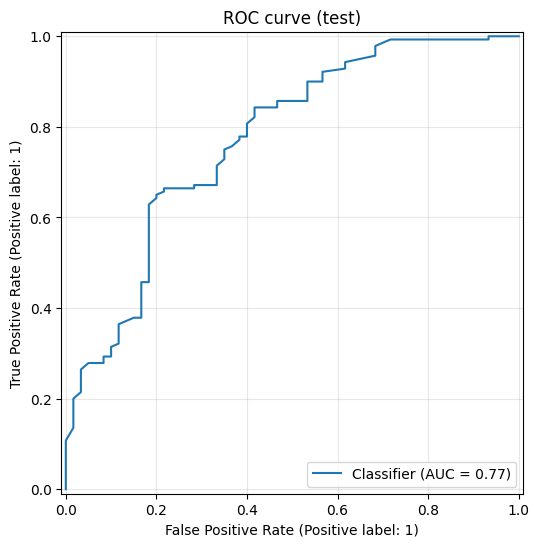

In [99]:
from sklearn.metrics import roc_auc_score, RocCurveDisplay

y_proba_test = rf_model.predict_proba(X_test)[:, 1]  # вероятность good=1
test_auc = roc_auc_score(y_test, y_proba_test)
print(f"Test ROC AUC: {test_auc:.3f}")

RocCurveDisplay.from_predictions(y_test, y_proba_test)
plt.title("ROC curve (test)")
plt.grid(True, alpha=.3)
plt.show()

___

## <mark>Сравнение моделей</mark>
Для оценки качества работы моделей был проведён 5-кратный стратифицированный кросс-валидационный анализ.  
В качестве метрик использовались:  
- **ROC AUC** — основная метрика для оценки качества классификации в задаче кредитного скоринга.  
- **Accuracy (%)** — дополнительная метрика для общего сравнения.

По результатам экспериментов наилучшие показатели показала модель **Случайного леса**:  
- средний ROC AUC ≈ 0.75  
- точность классификации ≈ 74.8%  

Таким образом, именно Случайный лес будет выбран в качестве **финальной скоринговой модели**, так как он демонстрирует наилучший баланс между качеством и устойчивостью результатов.

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y, random_state=42)

rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=42))
])

rf_model.fit(X_train, y_train)

display(rf_model)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'credit_amount',
                                                   'duration']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['sex', 'job', 'housing',
                                                   'saving_accounts',
                                                   'checking_account',
                                                   'purpose'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=300, random_state=42))])

In [101]:
# Сохранение модели
import joblib

try:
    joblib.dump(rf_model, '../src/models/rf_model.pkl')
    print('1. Модель Random Forest успешно сохранена!\nsrc/models/rf_model.pkl')
    joblib.dump(preprocessor, '../src/models/preprocessor.pkl')
    print('2. Препроцессор успешно сохранен!\nsrc/models/preprocessor.pkl')
except Exception as e:
    print(f'Ошибка при сохранении модели:\n{e}')

1. Модель Random Forest успешно сохранена!
src/models/rf_model.pkl
2. Препроцессор успешно сохранен!
src/models/preprocessor.pkl


# <mark>4. ОТЧЁТ</mark>

**Цель моделирования** заключалась в том, чтобы построить систему кредитного скоринга, которая по данным о клиентах банка будет предсказывать вероятность невозврата кредита.
Основная метрика — ```ROC AUC```, так как классы несбалансированы и важно корректно ранжировать клиентов по риску. Дополнительно учитывалась Accuracy.

Для оценки применялись три алгоритма:
- Logistic Regression — интерпретируемая линейная модель, дающая базовый уровень качества.
- Random Forest — ансамбль решающих деревьев, хорошо работающий с табличными данными.
- Gradient Boosting — бустинг над деревьями, умеющий выявлять сложные нелинейные зависимости.

Каждая модель обучалась в едином пайплайне:
- Числовые признаки масштабировались (StandardScaler),
- Категориальные кодировались (OneHotEncoder),
- Применялась 5-кратная стратифицированная кросс-валидация.

Модель **СЛУЧАЙНОГО ЛЕСА** показала лучшие результаты (```ROC-AUC=0.748321; процент точность=74.83%```) и была выбрана главной моделью для предсказания дефолта.
___

# 5. Проверка модели, статистические итоги

In [102]:
# Предсказанные вероятности к классу 0 (неплательщики)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Таблица сравнения реальных и предсказанных вероятностей
test_results = X_test.copy()
test_results['true_risk'] = y_test.values
test_results['predicted_proba'] = y_pred_proba

potential_defaulters = test_results.sort_values(by="predicted_proba", ascending=False).head(10)
potentials = test_results.sort_values(by="predicted_proba", ascending=True).head(10) 

print(f'--- Предсказанные потенцильные дефолты ---')
display(potential_defaulters)
print(f'--- Предсказанные потенцильные НАДЁЖНЫЕ клиенты ---')
display(potentials)

--- Предсказанные потенцильные дефолты ---


,age,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose,monthly_payment,true_risk,predicted_proba
514,54,male,2,own,no_info,no_info,2255,24,car,93.958333,1,0.996667
356,49,male,2,own,no_info,no_info,2331,12,radio/TV,194.250000,1,0.996667
486,52,male,2,own,little,no_info,3077,12,radio/TV,256.416667,1,0.990000
694,28,male,2,own,little,no_info,2284,24,radio/TV,95.166667,1,0.983333
214,51,male,2,own,no_info,no_info,3342,36,radio/TV,92.833333,1,0.980000
238,35,female,2,own,little,no_info,1291,12,radio/TV,107.583333,1,0.976667
638,34,female,2,own,little,no_info,1493,12,radio/TV,124.416667,1,0.966667
269,25,male,2,own,no_info,no_info,999,24,radio/TV,41.625000,1,0.963333
447,35,male,2,own,little,moderate,2576,7,radio/TV,368.000000,1,0.960000
977,42,male,2,own,no_info,moderate,2427,18,business,134.833333,1,0.960000


--- Предсказанные потенцильные НАДЁЖНЫЕ клиенты ---


,age,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose,monthly_payment,true_risk,predicted_proba
131,29,male,2,own,little,little,6887,36,education,191.305556,0,0.146667
812,24,male,2,own,little,little,9629,36,car,267.472222,0,0.180000
788,50,male,2,free,little,moderate,6224,48,education,129.666667,0,0.230000
736,23,female,3,rent,little,moderate,11560,24,car,481.666667,0,0.240000
481,26,male,2,own,little,moderate,1201,24,car,50.041667,1,0.256667
634,25,female,1,own,little,moderate,1355,24,car,56.458333,0,0.260000
814,46,male,2,free,little,little,3931,48,car,81.895833,0,0.263333
444,30,female,3,own,little,moderate,5096,48,furniture/equipment,106.166667,0,0.266667
850,33,male,2,rent,little,little,2235,20,car,111.750000,0,0.270000
983,26,male,2,own,little,little,8229,36,car,228.583333,0,0.283333


## ⚠️ Примеры потенциальных дефолтов

Ниже приведены примеры клиентов, которые по результатам работы модели попали в группу повышенного риска невозврата кредита:

| ID  | Возраст | Пол    | Жильё  | Saving Account | Checking Account | Сумма кредита | Срок (мес.) | Цель       | Ежемесячный платёж | Вероятность невозврата |
|-----|---------|--------|--------|----------------|------------------|---------------|-------------|------------|--------------------|------------------------|
| 812 | 24      | male   | own    | little         | little           | 9629          | 36          | car        | 267.5              | **82%**                |
| 736 | 23      | female | rent   | little         | moderate         | 11560         | 24          | car        | 481.7              | **76%**                |
| 788 | 50      | male   | free   | little         | moderate         | 6224          | 48          | education  | 129.7              | **77%**                |


> Эти примеры подтверждают выявленные закономерности:  
> - молодые клиенты с низкими накоплениями и крупными кредитами чаще всего оказываются в зоне риска,  
> - длительные сроки кредитования повышают вероятность невозврата,  
> - кредиты на *car* и *education* характеризуются повышенной рисковостью.
___
## ✅ Примеры надёжных клиентов

Ниже приведены примеры клиентов, которые по результатам работы модели имеют низкую вероятность невозврата кредита:

| ID  | Возраст | Пол    | Жильё | Saving Account | Checking Account | Сумма кредита | Срок (мес.) | Цель       | Ежемесячный платёж | Вероятность невозврата |
|-----|---------|--------|-------|----------------|------------------|---------------|-------------|------------|--------------------|------------------------|
| 54  | 54      | male   | own   | no_info        | no_info          | 2255          | 24          | car        | 93.96              | **0.3%**               |
| 356 | 49      | male   | own   | no_info        | no_info          | 2331          | 12          | radio/TV   | 194.25             | **0.3%**               |
| 486 | 52      | male   | own   | little         | no_info          | 3077          | 12          | radio/TV   | 256.42             | **1.0%**               |
| 214 | 51      | male   | own   | no_info        | no_info          | 3342          | 36          | radio/TV   | 92.83              | **2.0%**               |
| 238 | 35      | female | own   | little         | no_info          | 1291          | 12          | radio/TV   | 107.58             | **2.3%**               |

>📈 Общие закономерности:  
> - возрастные клиенты (35–55 лет),  
> - наличие собственного жилья,  
> - относительно небольшие суммы кредитов,  
> - низкие ежемесячные платежи,  
> - часто цель кредита — *radio/TV* (мелкие покупки).  

___
# ✅ Заключение

В рамках проекта по задаче кредитного скоринга (German Credit Dataset) были выполнены следующие шаги:

1. **Подготовка и очистка данных**  
   - удалены ненужные поля (ID),  
   - обработаны пропуски в признаках `saving_accounts` и `checking_account` (замена на `no_info`),  
   - преобразован целевой признак `risk` в бинарный формат.

2. **Разведывательный анализ (EDA)**  
   - проведено исследование распределений числовых и категориальных признаков,  
   - выявлены зависимости между характеристиками клиентов и вероятностью дефолта,  
   - замечены факторы риска: молодой возраст, низкие сбережения, длительный срок кредита.

3. **Feature Engineering**  
   - добавлены новые признаки: ежемесячный платёж, группировка возраста и длительности кредита, бинарные индикаторы наличия счетов,  
   - сформированы взаимодействия признаков (например, «большой кредит + низкие сбережения»).

4. **Моделирование**  
   - построены и протестированы три модели: Logistic Regression, Random Forest, Gradient Boosting,  
   - использована 5-кратная стратифицированная кросс-валидация,  
   - **лучшая модель — Random Forest** со средним ROC AUC ≈ **0.75**.

5. **Интерпретация результатов**  
   - важнейшие признаки: возраст, сумма кредита, длительность кредита, состояние сберегательного/текущего счёта,  
   - выявлено: молодые клиенты с низкими накоплениями и крупными кредитами (особенно на автомобиль или образование) чаще попадают в группу риска.

6. **Примеры клиентов**  
   - ⚠️ Потенциальные неплательщики: молодые клиенты (<30 лет) с крупными кредитами и низкими накоплениями, вероятность дефолта > 0.8.  
   - ✅ Надёжные клиенты: клиенты среднего и старшего возраста с собственным жильём, умеренными суммами кредитов и низкой нагрузкой, вероятность дефолта < 0.05.

---

## 📌 Итог
Построенная модель кредитного скоринга на основе **Random Forest** может использоваться как рабочий прототип для оценки рисков дефолта.  
Она демонстрирует адекватное качество, выявляет закономерности риска и может служить основой для внедрения скоринговой системы в продакшн.
